In [2]:
from transformers import ViltProcessor, ViltModel, ViltFeatureExtractor
from PIL import Image
import requests
from cub_with_attribute import Cub2011
import sys
sys.path.append('../')
from models.vilt import ViLT

model = ViLT()



Some weights of the model checkpoint at dandelin/vilt-b32-mlm-itm were not used when initializing ViltModel: ['mlm_score.transform.LayerNorm.weight', 'itm_score.fc.weight', 'mlm_score.transform.dense.weight', 'mlm_score.transform.dense.bias', 'mlm_score.bias', 'itm_score.fc.bias', 'mlm_score.transform.LayerNorm.bias', 'mlm_score.decoder.weight']
- This IS expected if you are initializing ViltModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
#create the text prompts
def create_text_prompts(args):
    with open(args.data_path + '/CUB_200_2011/attributes.txt', 'r') as f:
        lines = f.readlines()
    text_prompts = []
    for line in lines:

        #base that will be used for every image
        start = 'The bird has a '

        #get the words before seeing the descriptor
        beginning = ''
        seen = False


        for i in line.split()[1].split('_'):

            #:: signigifies that the attribute value is on the other side
            if '::' in i:
                first_half = i.split('::')[0]
                second_half = i.split('::')[1]
                seen = True

            #if we have seen the descriptor, we are done and ( signifies that
            if '(' in i:
                break
            if i != 'has':
                if '::' in i: continue
                if seen: second_half += ' ' + i
                else: beginning += i + ' '
        start += second_half + ' ' + beginning  + first_half
        text_prompts.append(start)
    return text_prompts

In [12]:
from torch.utils.data import DataLoader
import torch
import numpy as np

dataset_args = {
                 'root': '../data/',
                 'attribute_idx_amount': 1,
                 'normalize': False,
                 'crop_size': 448,
                 'brightness': 0.4, 
                 'contrast': 0.4, 
                 'saturation': .2, 
                 'hue': .1, 
                 'color_jitter_prob': 0, 
                 'gray_scale_prob': 0, 
                 'horizontal_flip_prob': 0.5, 
                 'gaussian_prob': 0, 
                 'min_scale': 0.9, 
                 'max_scale': 0.95}
train_dataset = Cub2011(dataset_args['root'], dataset_args, download=False, normalize = dataset_args['normalize'])
dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    num_workers=1,
    pin_memory=False,
    drop_last=True,
    persistent_workers=True
)



Not normalizing in DataLoader


In [13]:
args = type('', (), {})()
args.data_path = '../data/'
args.attribute_idx_amount = 1

text_prompts = np.array(create_text_prompts(args))

for i, data in enumerate(dataloader): break
images, attributes, certainty, class_labels = data['image'], data['attributes'].cuda(), data['certainty'].cuda(), data['class'].cuda()
if args.attribute_idx_amount > 1:
    arr = text_prompts[data['attribute_idx']]
    correct_prompts = ['. '.join(i) for i in list(arr)]
elif args.attribute_idx_amount == 1:
    correct_prompts = list(text_prompts[data['attribute_idx']])
else:
    correct_prompts = ['' for i in range(len(images))]

In [21]:
data['attribute_idx']

tensor([264,  75])

In [28]:
np.where(data['attributes'][1] == 1)

(array([  4,  10,  25,  59,  75,  80,  91,  97, 121, 145, 149, 157, 164,
        214, 220, 227, 236, 240, 249, 279, 289, 294, 305, 308]),)

In [45]:
torch.tensor([[torch.tensor(1), torch.tensor(2)], [torch.tensor(2)]][0])

tensor([1, 2])

In [37]:
model = model.cuda()
out = model(correct_prompts, data['image'].cuda())

In [40]:
out[0][data['attribute_idx']]

/opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [1,0,0], thread: [96,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [1,0,0], thread: [97,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [1,0,0], thread: [98,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: [1,0,0], thread: [99,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/cuda/IndexKernel.cu:91: operator(): block: 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

['The bird has a brown leg color', 'The bird has a notched tail tail shape']


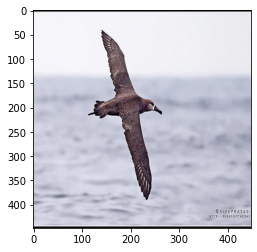

In [26]:
print(correct_prompts)
import matplotlib.pyplot as plt
plt.imshow(images[0].permute(1,2,0))

In [9]:
#feature extract
import torch
import numpy as np
images = [i for i in data['image']]
feature_extractor = ViltFeatureExtractor.from_pretrained("dandelin/vilt-b32-mlm")
out = feature_extractor(images, return_tensors="pt", padding = True)



In [24]:
import numpy as np

with open('../data/' + '/CUB_200_2011/attributes.txt', 'r') as f:
    lines = f.readlines()
text_prompts = []
for line in lines:

    #base that will be used for every image
    start = 'The bird has a '

    #get the words before seeing the descriptor
    beginning = ''
    seen = False


    for i in line.split()[1].split('_'):

        #:: signigifies that the attribute value is on the other side
        if '::' in i:
            first_half = i.split('::')[0]
            second_half = i.split('::')[1]
            seen = True

        #if we have seen the descriptor, we are done and ( signifies that
        if '(' in i:
            break
        if i != 'has':
            if '::' in i: continue
            if seen: second_half += ' ' + i
            else: beginning += i + ' '
    start += second_half + ' ' + beginning  + first_half
    text_prompts.append(start)

text_prompts = np.array(text_prompts)
correct_prompts = list(text_prompts[data['attribute_idx']])

In [32]:
data['image'][0]

tensor([[[2.1462, 2.1462, 2.1462,  ..., 2.0948, 2.0948, 2.0948],
         [2.0263, 2.0263, 2.0434,  ..., 1.8722, 1.8722, 1.8722],
         [2.0948, 2.0948, 2.0948,  ..., 1.9407, 1.9578, 1.9578],
         ...,
         [1.5297, 1.4783, 1.5125,  ..., 1.3070, 1.2557, 1.1872],
         [1.5639, 1.5810, 1.5810,  ..., 1.3070, 1.2385, 1.1700],
         [1.6324, 1.6324, 1.6324,  ..., 1.2899, 1.2385, 1.2043]],

        [[2.3235, 2.3235, 2.3235,  ..., 2.2710, 2.2535, 2.2535],
         [2.2010, 2.1835, 2.2010,  ..., 2.0434, 2.0609, 2.0609],
         [2.2360, 2.2360, 2.2535,  ..., 2.1310, 2.1485, 2.1485],
         ...,
         [1.6933, 1.6758, 1.7108,  ..., 1.5007, 1.4482, 1.3782],
         [1.7283, 1.7458, 1.7283,  ..., 1.5007, 1.4307, 1.3606],
         [1.7808, 1.7808, 1.7808,  ..., 1.4832, 1.4307, 1.3957]],

        [[2.5529, 2.5529, 2.5529,  ..., 2.5006, 2.5006, 2.5006],
         [2.4831, 2.5006, 2.5180,  ..., 2.3611, 2.3611, 2.3611],
         [2.5529, 2.5529, 2.5703,  ..., 2.4308, 2.4483, 2.

In [38]:
images = []
for i in data['image']:
    images.append(i)
processor(images, correct_prompts, return_tensors="pt", padding = True)


{'input_ids': tensor([[ 101, 1996, 4743, 2038, 1037, 4462, 3356, 5725, 3609,  102],
        [ 101, 1996, 4743, 2038, 1037, 2829, 3759, 3609,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]), 'pixel_values': tensor([[[[-0.7098, -0.7098, -0.7098,  ..., -0.9451, -0.9451, -0.9451],
          [-0.8118, -0.8118, -0.8118,  ..., -0.3333, -0.3333, -0.3333],
          [-0.9686, -0.9686, -0.9686,  ...,  0.6941,  0.6941,  0.6941],
          ...,
          [ 0.1216,  0.1373,  0.1608,  ..., -0.5451, -0.6314, -0.6784],
          [ 0.2078,  0.2157,  0.2314,  ..., -0.5451, -0.6000, -0.6314],
          [ 0.2627,  0.2627,  0.2627,  ..., -0.5373, -0.5843, -0.6000]],

         [[-0.3569, -0.3490, -0.3490,  ..., -0.4824, -0.4824, -0.4824],
          [-0.4510, -0.4588, -0.4667,  ..., -0.6471, -0.6471, -0.6471],
          [-0.6078, -0.6235, -0.647

In [40]:
inputs['pixel_values'].shape

torch.Size([2, 3, 384, 512])

In [35]:
correct_prompts

['The bird has a grey upper tail color', 'The bird has a brown throat color']

In [31]:
data['image'].shape

torch.Size([2, 3, 224, 224])

In [17]:
# prepare image and text
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "hello world"
url2 = 'https://farm1.staticflickr.com/79/269579885_4c423901f9_z.jpg'
image2 = Image.open(requests.get(url2, stream=True).raw)



inputs = processor([image, image2], [text, text], return_tensors="pt")
for i in inputs:
    inputs[i] = inputs[i].cuda()
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)

In [12]:
inputs

{'input_ids': tensor([[ 101, 7592, 2088,  102],
        [ 101, 7592, 2088,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 1, 1]]), 'pixel_values': tensor([[[[ 0.1059,  0.1294,  0.1373,  ..., -0.2000, -0.1922, -0.1922],
          [ 0.0824,  0.1137,  0.1608,  ..., -0.2235, -0.1373, -0.2314],
          [ 0.0980,  0.1765,  0.1529,  ..., -0.1922, -0.2078, -0.2235],
          ...,
          [ 0.8353,  0.8353,  0.8196,  ...,  0.4980,  0.4667,  0.4510],
          [ 0.8118,  0.8039,  0.7882,  ...,  0.0353,  0.0667, -0.1137],
          [ 0.8667,  0.9059,  0.7098,  ..., -0.3490, -0.4039, -0.4275]],

         [[-0.8039, -0.8118, -0.8275,  ..., -0.9137, -0.8824, -0.9137],
          [-0.8118, -0.8039, -0.7961,  ..., -0.9059, -0.8824, -0.8980],
          [-0.7961, -0.7569, -0.7882,  ..., -0.8745, -0.8588, -0.9059],
          ...,
          [-0.2627, -0.2627, -0.2549,  ..., -0.5686, -0.5216, -0.5608],
          [-0.3176, 